#Анализ временных рядов

##Часть первая

In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from dateutil.relativedelta import relativedelta

###Визуальный анализ ряда

In [ ]:
data = pd.read_csv("data.csv", ';', index_col=['month'], parse_dates=['month'], dayfirst=True)

<ipython-input-105-48507d71819d>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  data = pd.read_csv("data.csv", ';', index_col=['month'], parse_dates=['month'], dayfirst=True)


In [ ]:
data

,Unnamed: 0,WAG_C_M
month,,
1993-01-01,0,15.3
1993-02-01,1,19.1
1993-03-01,2,23.6
1993-04-01,3,30.6
1993-05-01,4,37.5
...,...,...
2016-04-01,279,36497.0
2016-05-01,280,37270.0
2016-06-01,281,38447.0


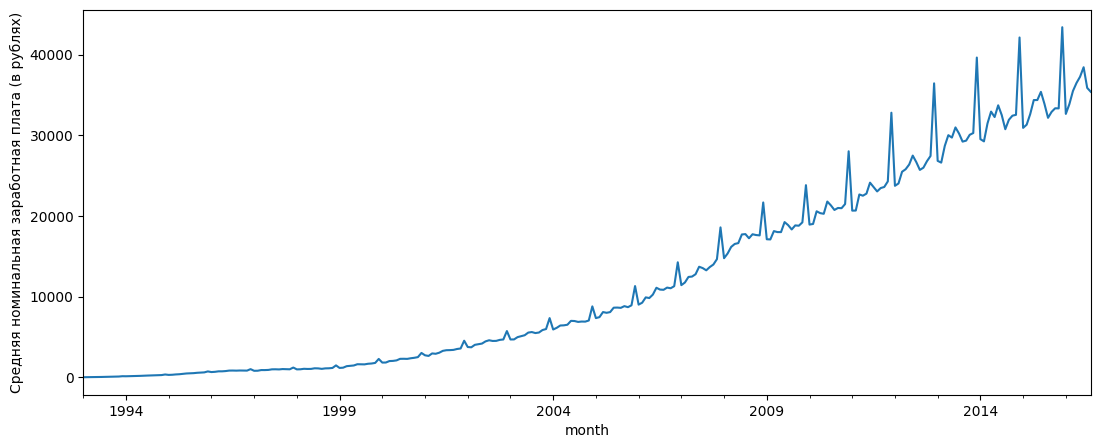

In [ ]:
fig = plt.figure(figsize=(13, 5))
data.WAG_C_M.plot()
plt.ylabel('Средняя номинальная заработная плата (в рублях)')
plt.show() 

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.996491


<Figure size 1300x500 with 0 Axes>

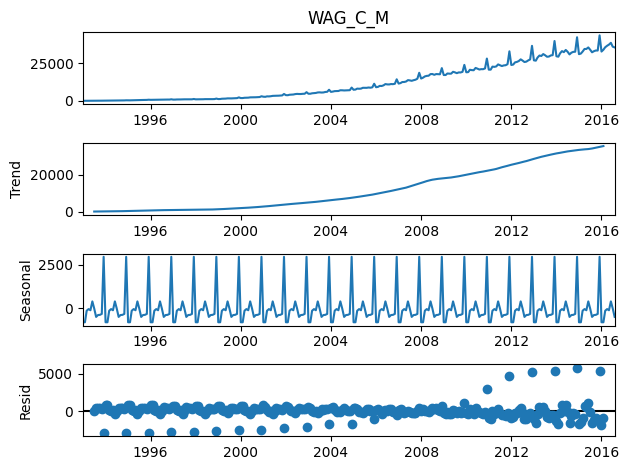

In [ ]:
fig = plt.figure(figsize=(13, 5))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

###Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.263044
Критерий Дики-Фуллера: p=0.757007


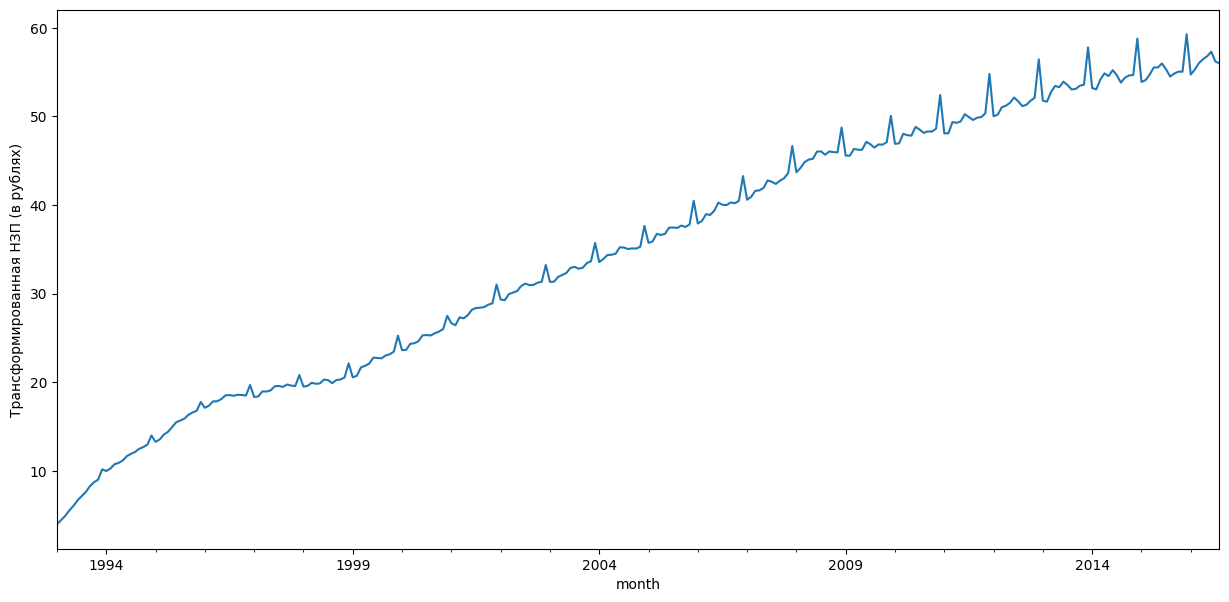

In [ ]:
data['WAG_C_M_box'], lmbda = stats.boxcox(data.WAG_C_M)
fig = plt.figure(figsize=(15, 7))
data.WAG_C_M_box.plot()
plt.ylabel(u'Трансформированная НЗП (в рублях)')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box)[1])

###Выбор порядка дифференцирования

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.007911


<Figure size 1500x1000 with 0 Axes>

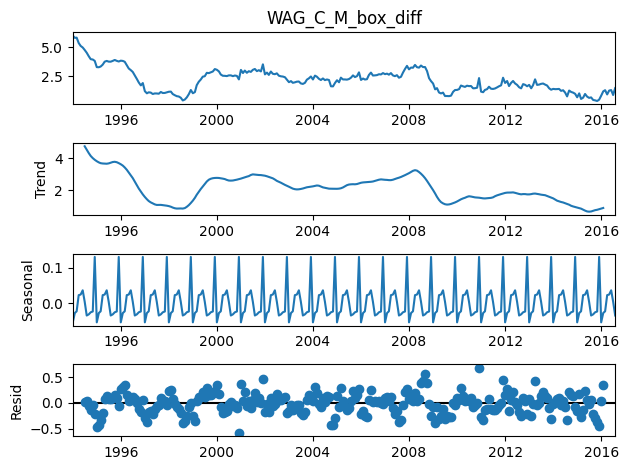

In [ ]:
data['WAG_C_M_box_diff'] = data.WAG_C_M_box - data.WAG_C_M_box.shift(12)
fig = plt.figure(figsize=(15, 10))
sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1500x1000 with 0 Axes>

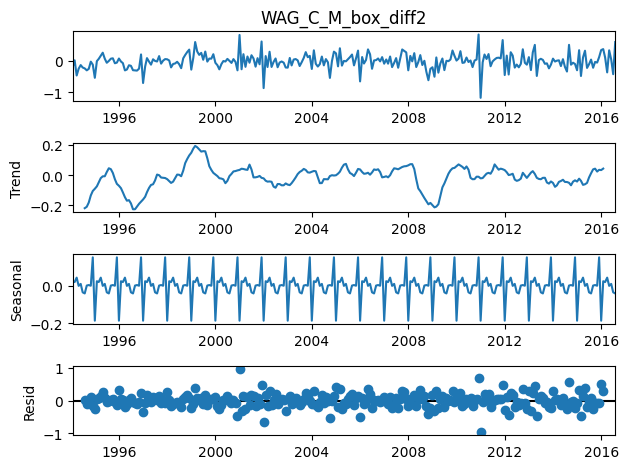

In [ ]:
data['WAG_C_M_box_diff2'] = data.WAG_C_M_box_diff - data.WAG_C_M_box_diff.shift(1)
fig = plt.figure(figsize=(15, 10))
sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff2[13:])[1])

###Выбор начальных приближений для p, q, P, Q, d

Построим график для автокорреляционной функции

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


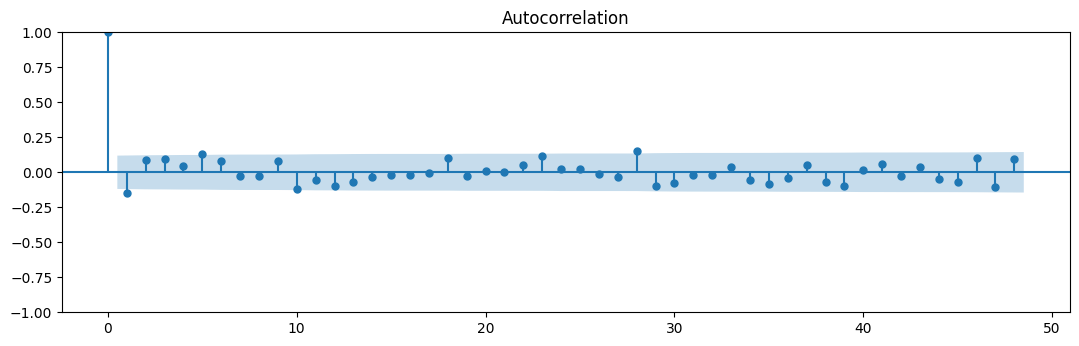

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


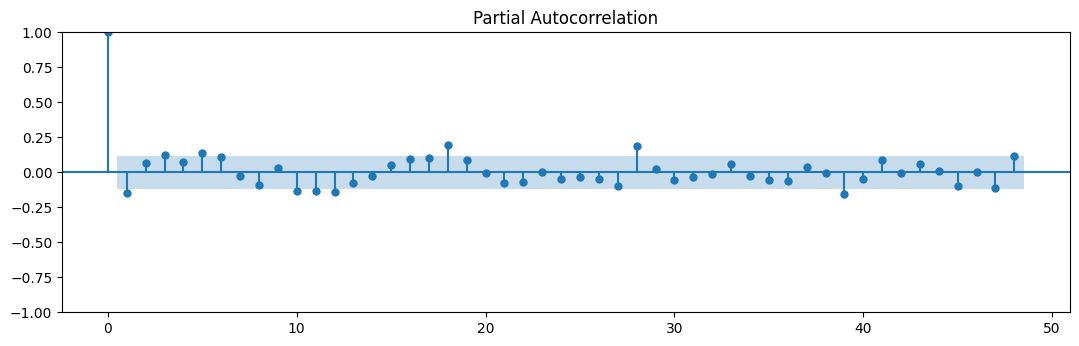

In [ ]:
fig = plt.figure(figsize=(13, 8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.show()
fig = plt.figure(figsize=(13, 8))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.show()

По графику автокорреляционной функции (ACF) определим параметры q и Q:

1) Так как значения коэффициентов автокорреляции на сезонных лагах несущественны (их значения не покидают коридор значимости, обозначенный синим цветом), то параметр Q = 0

2) Так как значения коэффициентов автокорреляции среди первых несезонных лагов значимы только на первом, то параметр q = 1

По графику частичной автокорреляционной функции (PACF) определим параметры p и P:

1) Так как значения коэффициентов автокорреляции на сезонных лагах существенны только при лагах, равными 12 и 48, при этом максимум дастигается на 12 лаге, то параметр P = 1

2) Так как значения коэффициентов автокорреляции среди первых несезонных лагов значимы только на первом, то параметр p = 1

Так как к исходному ряду было применено одно сезонное и одно обычное дифференцирование, то параметры D = 1 и d = 1

Далее значения параметров q, Q, p, P будут определяться перебором (от нуля до установленных значений): из разных значений гиперпараметров выбираются те, у которых значение критерия Акаике будет минимальным.

In [ ]:
qs = range(0, 2)
Qs = range(0, 1)

ps = range(0, 2)
Ps = range(0, 2)

d = 1
D = 1 

Путем перебора параметров p, P, q, Q получим 8 возможных наборов параметров, на каждом из которых обучим модель

In [ ]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

###Обучение и сравнение моделей-кандидатов, выбор победителя

In [ ]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 1.47 s, sys: 1.1 s, total: 2.56 s
Wall time: 1.44 s


Сравним наборы параметров полученных моделей и соответствущие этим наборам коэффициенты Акаике:

In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters       aic
5  (1, 0, 1, 0)  4.383761
3  (0, 1, 1, 0)  5.428847
7  (1, 1, 1, 0)  6.103035
4  (1, 0, 0, 0)  6.703476
2  (0, 1, 0, 0)  7.652032


Видим, что модель с параметрами p = 1, q = 0, P = 1, Q = 0 лучше всего удовлетворяет критерию Акаике ввиду минимального значения коэффицинта среди других моделей

###Анализ остатков построенной модели

Прежде, чем приступать к прогнозированию с помощью модели, необходимо убедиться в том, что остатки (разница между фактическими значениями и значениями модели) несмещены, стационарны и неавтокоррелированны.

Для оценки несмещенности остатков воспользуемся критерием Стьюдента

Для оценки стационарности остатков восплользуемся критерим Дики-Фуллера

Для оценки неавтокоррелированности воспользуемся критерием Льюнга-Бокса

С помощью метода summury посмотрим на параметры лучшей модели 

In [ ]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   0.808
Date:                            Wed, 17 May 2023   AIC                              4.384
Time:                                    02:17:31   BIC                             15.190
Sample:                                01-01-1993   HQIC                             8.723
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1651      0.046     -3.558      0.000      -0.256      -0.074
ar.S.L12      -0.1332      0.047   

Из блока с информацией об остатках видно, что критерий Льюнга-Бокса имеет уровень значимости 0.99 (Prob(Q)), благодаря чему можем уверенно утверждать, что остатки неавтокоррелированны 

Критерий Стьюдента: p=0.119860
Критерий Дики-Фуллера: p=0.000004


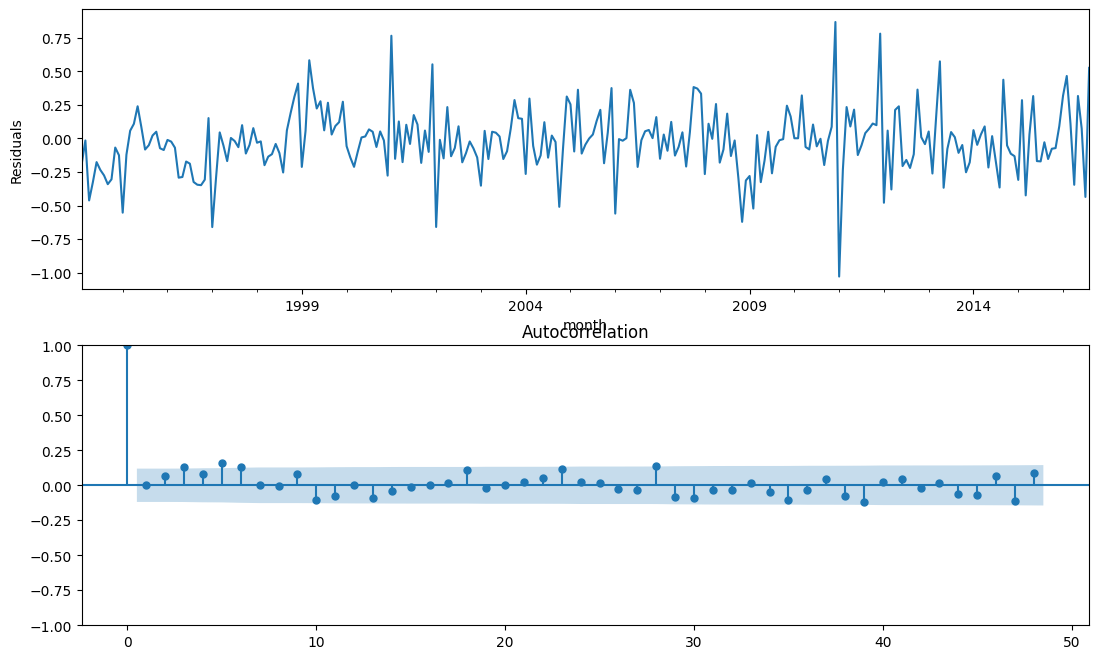

In [ ]:
fig = plt.figure(figsize=(13, 8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает исходные данные:

In [ ]:
def invboxcox(y,lmbda): #Функция для инвертирования функции Бокса-Кокса
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

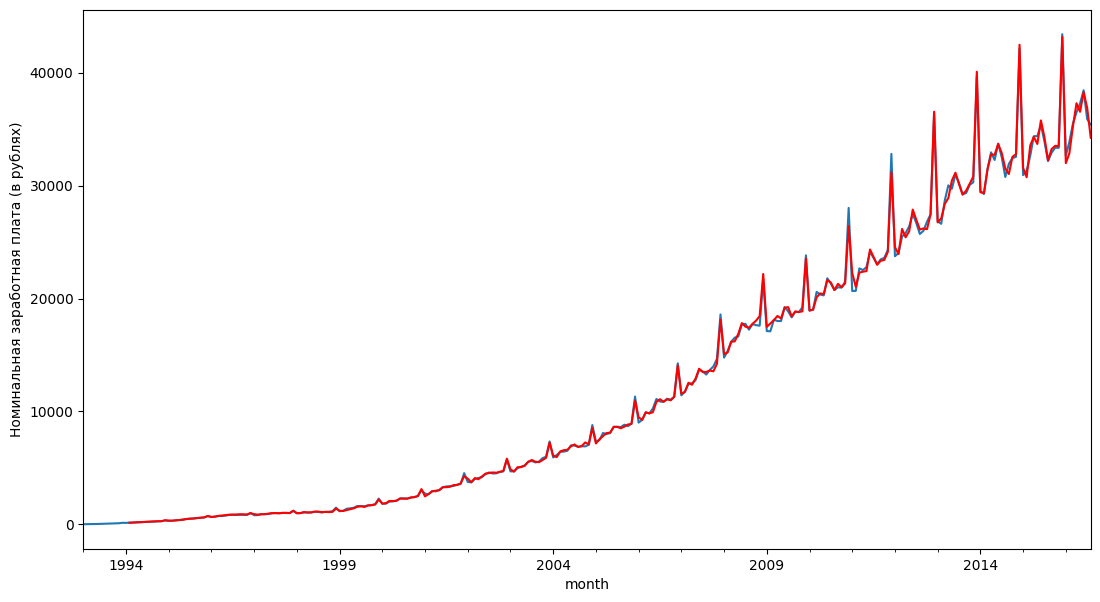

In [ ]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
fig = plt.figure(figsize=(13, 7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('Номинальная заработная плата (в рублях)')
plt.show()

###Прогнозирование с помощью финальной модели

Для получения прогноза воспользуемся методом выбранной модели predict и построим исходный ряд (синий цвет), предсказания модели (красный цвет) и реальные данные за прогнозируемый период (зеленый цвет)

<ipython-input-123-2beb6c81b458>:7: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  real_data = pd.read_csv("real_data.csv", ';', index_col=['month'], parse_dates=['month'], dayfirst=True)


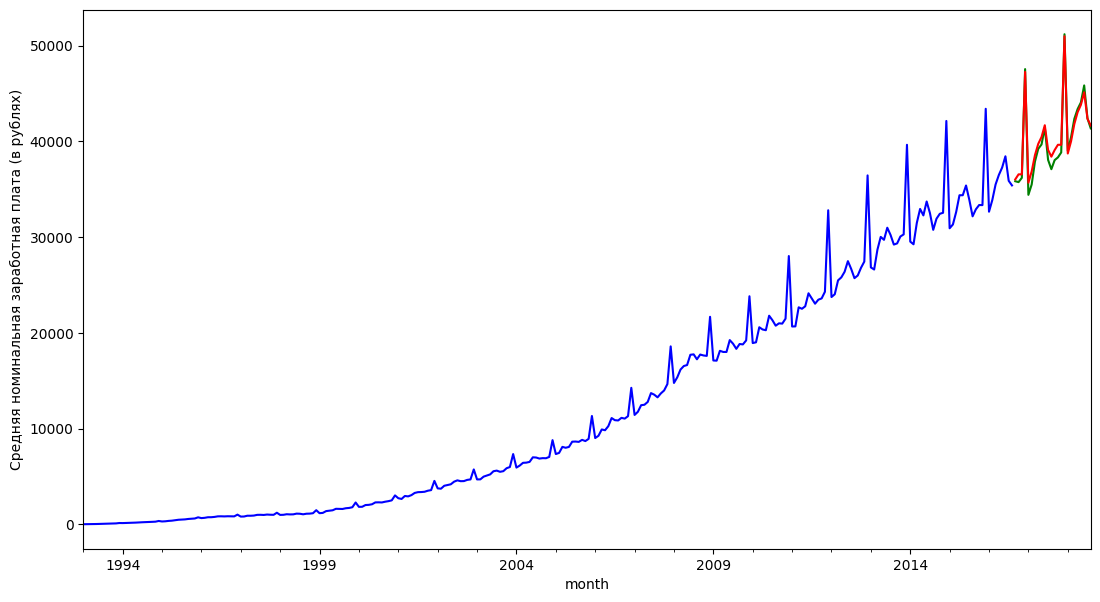

In [ ]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=284, end=307), lmbda)

real_data = pd.read_csv("real_data.csv", ';', index_col=['month'], parse_dates=['month'], dayfirst=True)

fig = plt.figure(figsize=(13, 7))
data2.WAG_C_M.plot(color='b')
real_data.WAG_C_M.plot(color='g')
data2.forecast.plot(color='r')
plt.ylabel('Средняя номинальная заработная плата (в рублях)')
plt.show()

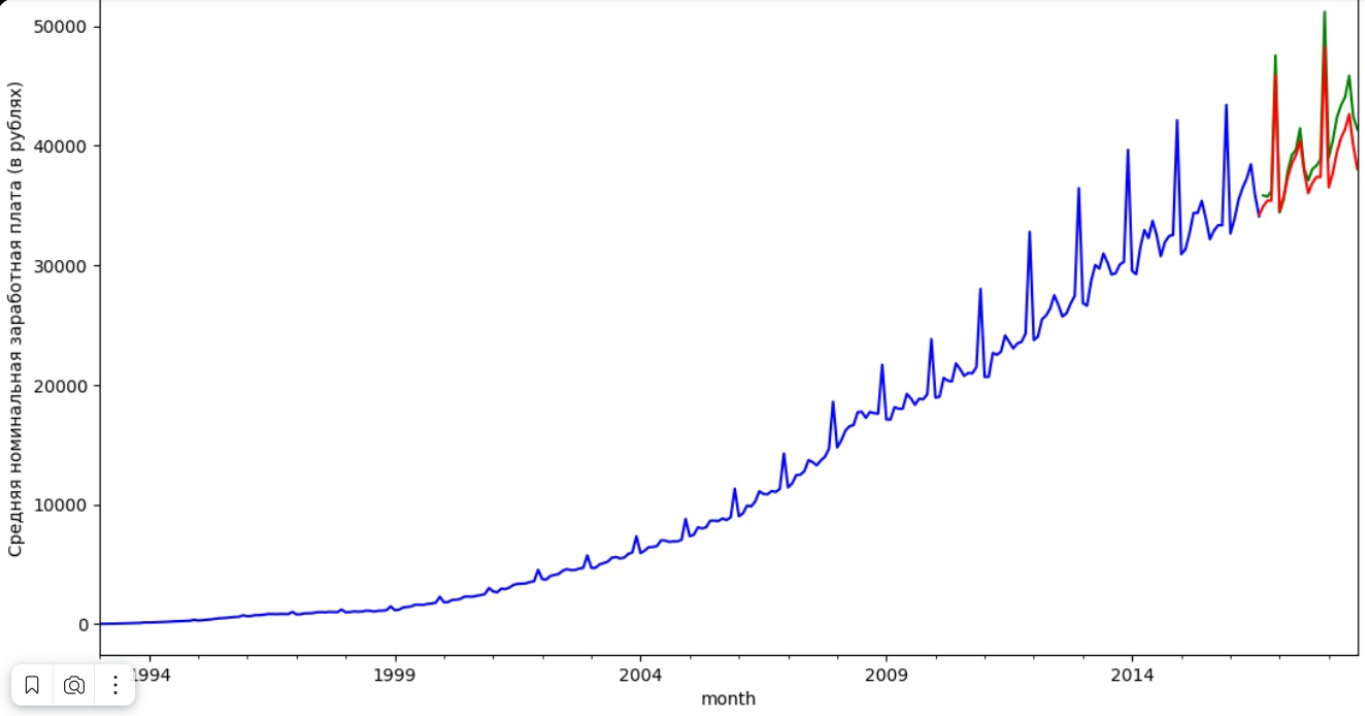

##Часть вторая

###Подготовка данных

###Однослойный перцептрон

###RNN

###LSTM

###Conv + LSTM